# PROJECT

## Introduction  
This notebook trains two models for a movie recommender system using the MovieLens 100K dataset:
- A user-based model using Neural Collaborative Filtering (NCF)
- An item similarity model using cosine similarity on embeddings

We will follow the full ML pipeline: data loading → preprocessing → modeling → saving.


## About Data
Columns:
- userId (int): Unique identifier for users
- movieId (int): Unique identifier for movies
- rating (float): Rating given by a user to a movie (range 0.5–5.0)
- timestamp (int): When the rating was given (not used now)
- title (object): Movie title
- genres (object): Movie genres


## `01` Import Libraries

In [ ]:
import pandas as pd  

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 


## `02` Read Data

In [13]:
ratings = pd.read_csv("../data/ratings.csv")
movies = pd.read_csv("../data/movies.csv")

df = ratings.merge(movies, on="movieId")

## `03` EDA

In [14]:
df

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,1494273047,Get Out (2017),Horror
100834,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi


In [16]:
print(df.shape)     

(100836, 6)


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   title      100836 non-null  object 
 5   genres     100836 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 4.6+ MB


In [ ]:
df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

Unique users: 610
Unique movies: 9724


<Axes: >

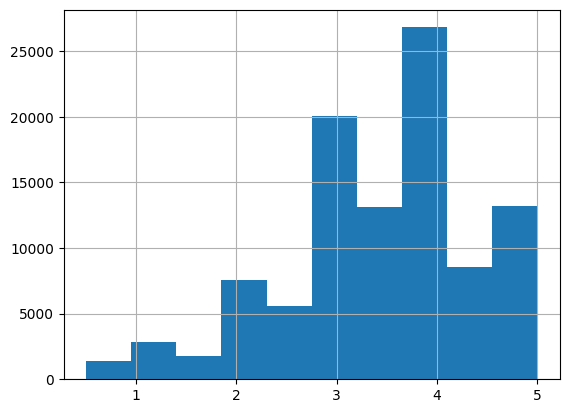

In [12]:
print("Unique users:", df['userId'].nunique())
print("Unique movies:", df['movieId'].nunique())
df['rating'].hist()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)